In [4]:
#%reload_ext watermark
%matplotlib inline

import os
import re
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import scipy.stats
# from metapool.metapool import *
# from metapool.util import (
#     join_dfs_from_files, extend_sample_accession_df,
#     extend_compression_layout_info, QIITA_STUDY_ID_KEY
# )

#%watermark -i -v -iv -m -h -p metapool,pandas,matplotlib,seaborn,scipy -u

# Knight Lab - FASTQ Comparison Workflow

### What is it?

This notebook compares two sequencing runs based on read count distribution and diversity metrics. This is useful for benchmarking two different sequencing runs, primer sets, instruments, etc.

### How it works

This workflow compares FASTQ files from two directories by:
1. Loading a plate map to match sample IDs 
2. Counting reads per sample from FASTQ files
3. Creating paired comparisons between runs
4. Producing statistical analyses and visualizations

### Inputs required

- Two directories containing FASTQ files (`.fastq` or `.fastq.gz`)
- A plate map file with sample information and well positions


## Step 1: Define Helper Functions

The following functions handle file processing and data manipulation:

In [5]:
def count_reads_fastq(file_path):
    """Count reads in a FASTQ file more efficiently"""
    try:
        count = 0
        if file_path.endswith(".gz"):
            with gzip.open(file_path, "rt") as handle:
                for i, _ in enumerate(handle):
                    if i % 4 == 0:  # only count header lines
                        count += 1
        else:
            with open(file_path, "rt") as handle:
                for i, _ in enumerate(handle):
                    if i % 4 == 0:
                        count += 1
        return count
    except Exception as e:
        print(f"Error counting reads in {file_path}: {e}")
        return 0

def build_read_count_df(fastq_dir, plate_map=None):
    """Build a dataframe of read counts from FASTQ files"""
    data = []
    fastq_dir_path = Path(fastq_dir)
    
    if not fastq_dir_path.exists():
        print(f"Warning: Directory {fastq_dir} not found")
        return pd.DataFrame(columns=["SampleID", "SampleFile", "ReadCount"])
    
    # parse out present samples via lookup table
    sample_id_lookup = {}
    if plate_map is not None and 'Sample_ID' in plate_map.columns:
        for _, row in plate_map.iterrows():
            sample_id = str(row['Sample_ID'])
            if pd.isna(sample_id) or sample_id is None:
                continue
            
            sample_id_lookup[sample_id] = {
                'sample_id': str(row['SampleID']),
                'well': row['Well'] if 'Well' in row else None
            }
    
    for file_path in fastq_dir_path.glob("*.[fF][aA][sS][tT][qQ]*"):
        fname = file_path.name
        if fname.endswith(".fastq") or fname.endswith(".fastq.gz"):
            try:
                matched_id = None
                
                # try to match against each Sample_ID in the plate map
                if plate_map is not None:
                    for plate_sample_id in sample_id_lookup:
                        if plate_sample_id in fname:
                            matched_id = sample_id_lookup[plate_sample_id]['sample_id']
                            break
                
                if matched_id is None:
                    print(f"Warning: Could not match sample ID from {fname}")
                    continue
                
                read_count = count_reads_fastq(str(file_path))
                
                data.append({
                    "SampleID": matched_id, 
                    "SampleFile": fname, 
                    "ReadCount": read_count
                })
            except Exception as e:
                print(f"Error processing {fname}: {e}")
    
    df = pd.DataFrame(data)
    if not df.empty:
        print(f"Sample IDs found in FASTQ files: {df['SampleID'].unique()[:10]}...")
    else:
        print("No sample IDs found in FASTQ files")
    return df

def load_plate_map(plate_map_path, skiprows=21):
    """Load and validate plate map file"""
    try:
        # try multiple file formats
        try:
            plate_map = pd.read_csv(plate_map_path, skiprows=skiprows)
        except Exception as e1:
            print(f"Standard CSV loading failed: {e1}")
            try:
                plate_map = pd.read_csv(plate_map_path, skiprows=skiprows, sep='\t')
            except Exception as e2:
                print(f"Tab-delimited loading failed: {e2}")
                plate_map = pd.read_csv(plate_map_path, sep='\t')
        
        print(f"Plate map columns: {plate_map.columns.tolist()}")
        
        req_cols = ["Sample_ID", "destination_well_384", "orig_name"]
        missing_cols = [col for col in req_cols if col not in plate_map.columns]
        
        if missing_cols:
            print(f"WARNING: Missing required columns in plate map: {missing_cols}")
            if "orig_name" not in plate_map.columns and "Sample_ID" in plate_map.columns:
                # extract numeric portion from Sample_ID as fallback, risky
                plate_map["orig_name"] = plate_map["Sample_ID"].apply(
                    lambda x: re.search(r'(\d+)', str(x)).group(1) if re.search(r'(\d+)', str(x)) else x
                )
                print(f"Created orig_name column from Sample_ID: {plate_map['orig_name'].tolist()[:5]}...")
        
        if "orig_name" in plate_map.columns and "destination_well_384" in plate_map.columns:
            plate_map = plate_map.dropna(subset=["orig_name", "destination_well_384"])
            
            plate_map = plate_map.rename(columns={
                "orig_name": "SampleID",
                "destination_well_384": "Well",
                "index": "Index1",
                "index2": "Index2"
            })
        elif "Sample_ID" in plate_map.columns and "destination_well_384" in plate_map.columns:
            plate_map = plate_map.dropna(subset=["Sample_ID", "destination_well_384"])
            
            plate_map = plate_map.rename(columns={
                "Sample_ID": "SampleID",
                "destination_well_384": "Well",
                "index": "Index1",
                "index2": "Index2"
            })
        else:
            print("ERROR: Could not find required columns in plate map")
            return pd.DataFrame()
        
        print(f"Sample IDs from plate map: {plate_map['SampleID'].tolist()[:10]}...")
        return plate_map
    except Exception as e:
        print(f"Error loading plate map: {e}")
        return pd.DataFrame()


## Step 2: Set Input Parameters

Provide the paths to your two FASTQ directories, plate map file, and output directory:

In [6]:
# update these paths with your data
fastq_dir_1 = "/qmounts/qiita_data/per_sample_FASTQ/216584"
fastq_dir_2 = "/qmounts/qiita_data/per_sample_FASTQ/216585"

plate_map_path = "TMI_5_CHILD_33_stubtest_iseq_samplesheet_plus_orig_name_dest_well_384 (1).csv"
output_dir = "metapool_test"

# create output directory
os.makedirs(output_dir, exist_ok=True)

## Step 3: Define Analysis Functions

The following functions handle data comparison and analysis.

In [9]:
def extract_well_info(df, well_column="Well"):
    """Extract row and column information from well IDs"""
    # validate well format (A1 to P24 for 384-well plate)
    valid_pattern = re.compile(r'^[A-P]([1-9]|1[0-9]|2[0-4])$')
    invalid_rows = df[~df[well_column].str.match(valid_pattern, na=False)]
    
    if not invalid_rows.empty:
        print(f"WARNING: Found {len(invalid_rows)} rows with invalid well format, skipping:")
        print(invalid_rows[["SampleID", well_column]].head())
    
    result = df[df[well_column].str.match(valid_pattern, na=False)].copy()
    
    # extract row letter and column number
    result["Row"] = result[well_column].str.extract(r'([A-P])')
    result["Column"] = result[well_column].str.extract(r'(\d{1,2})')
    result["Column"] = pd.to_numeric(result["Column"], errors='coerce')
    result = result.dropna(subset=["Row", "Column"])
    result["Column"] = result["Column"].astype(int)
    
    return result

def create_paired_comparison(df_1, df_2, plate_map):
    """Create a dataframe with proper pairing between first and second datasets"""
    # check unique sample counts
    plate_unique_samples = plate_map['SampleID'].nunique()
    df_1_unique_samples = df_1['SampleID'].nunique()
    df_2_unique_samples = df_2['SampleID'].nunique()
    
    print(f"Plate map unique sample IDs: {plate_unique_samples}")
    print(f"Dataset 1 unique sample IDs: {df_1_unique_samples}")
    print(f"Dataset 2 unique sample IDs: {df_2_unique_samples}")
    
    # check for sample ID overlap
    samples_1 = set(df_1['SampleID'].unique())
    samples_2 = set(df_2['SampleID'].unique())
    plate_samples = set(plate_map['SampleID'].unique())
    
    overlap_1_plate = len(samples_1.intersection(plate_samples))
    overlap_2_plate = len(samples_2.intersection(plate_samples))
    
    print(f"\nSample ID overlap - Dataset1/Plate: {overlap_1_plate}")
    print(f"Sample ID overlap - Dataset2/Plate: {overlap_2_plate}")
    
    # aggregate read counts by SampleID to handle R1/R2 pairs
    df_1_agg = df_1.groupby('SampleID').agg({
        'ReadCount': 'sum',
        'SampleFile': lambda x: ','.join(x)
    }).reset_index()
    
    df_2_agg = df_2.groupby('SampleID').agg({
        'ReadCount': 'sum',
        'SampleFile': lambda x: ','.join(x)
    }).reset_index()
    
    # merge plate map with read counts
    merged_1 = pd.merge(df_1_agg, plate_map[['SampleID', 'Well']], on="SampleID", how="inner")
    merged_1 = merged_1.rename(columns={
        "ReadCount": "ReadCount_1", 
        "SampleFile": "SampleFile_1"
    })
    
    merged_2 = pd.merge(df_2_agg, plate_map[['SampleID', 'Well']], on="SampleID", how="inner")
    merged_2 = merged_2.rename(columns={
        "ReadCount": "ReadCount_2", 
        "SampleFile": "SampleFile_2"
    })
    
    # merge both datasets using inner join on SampleID
    merged = pd.merge(
        merged_1[['SampleID', 'Well', 'ReadCount_1', 'SampleFile_1']], 
        merged_2[['SampleID', 'ReadCount_2', 'SampleFile_2']], 
        on="SampleID", 
        how="inner"
    )
    
    # count valid data points
    valid_1 = merged[merged['ReadCount_1'].notna()]['SampleID'].nunique()
    valid_2 = merged[merged['ReadCount_2'].notna()]['SampleID'].nunique()
    valid_both = merged.dropna(subset=["ReadCount_1", "ReadCount_2"])['SampleID'].nunique()
    
    print(f"\nValid data points - Dataset1: {valid_1}, Dataset2: {valid_2}, Both: {valid_both}")
    
    # replace zeros with NaN
    merged['ReadCount_1'] = merged['ReadCount_1'].replace(0, np.nan)
    merged['ReadCount_2'] = merged['ReadCount_2'].replace(0, np.nan)
    
    merged["FoldChange"] = merged["ReadCount_2"] / merged["ReadCount_1"]
    
    return merged

def create_positional_comparison(merged):
    """Create comparisons based on plate position (odd/even columns)"""
    result = merged.copy()
    
    result['Row'] = result['Well'].str[0]  # first character is the row letter
    result['Column'] = result['Well'].str[1:].astype(int)  # rest is the column number
    
    result['Log2FoldChange'] = np.nan
    
    # calculate fold changes for each row in the plate
    for row_letter, group in result.groupby("Row"):
        group = group.sort_values("Column")
        
        for i, row in group.iterrows():
            col = row["Column"]
            
            # odd columns (baseline) get a fold change of 0 (log2(1) = 0)
            if col % 2 == 1:
                result.loc[i, 'Log2FoldChange'] = 0
            # even columns get fold change relative to previous odd column
            else:
                # find matching baseline (previous odd column in same row)
                baseline_col = col - 1
                baseline = group[group["Column"] == baseline_col]
                
                if not baseline.empty and pd.notna(baseline['ReadCount_1'].values[0]) and pd.notna(row['ReadCount_2']):
                    fold_change = np.log2(row['ReadCount_2'] / baseline['ReadCount_1'].values[0])
                    result.loc[i, 'Log2FoldChange'] = fold_change
    
    return result

In [10]:
def create_simple_visualizations(merged, output_dir):
    """Create simplified visualizations comparing two datasets"""
    valid_data = merged.dropna(subset=["ReadCount_1", "ReadCount_2"])
    valid_count = valid_data['SampleID'].nunique()
    print(f"Creating visualizations with {valid_count} valid data points")
    
    if valid_count == 0:
        print("WARNING: No valid data points for visualizations!")
        return
    
    # ===== SCATTER PLOT =====
    plt.figure(figsize=(8, 8))
    
    # create scatter plot
    plt.scatter(
        valid_data["ReadCount_1"], 
        valid_data["ReadCount_2"],
        alpha=0.7, 
        s=50, 
        edgecolor='black', 
        linewidth=0.5,
        color='royalblue'
    )
    
    # add regression line
    sns.regplot(
        x=valid_data["ReadCount_1"], 
        y=valid_data["ReadCount_2"],
        scatter=False,
        line_kws={'color': 'red', 'linestyle': '-', 'linewidth': 2}
    )
    
    # set log scales
    plt.xscale("log")
    plt.yscale("log")
    
    # add diagonal identity line (y=x)
    xlim = plt.xlim()
    ylim = plt.ylim()
    min_val = min(xlim[0], ylim[0])
    max_val = max(xlim[1], ylim[1])
    plt.plot([min_val, max_val], [min_val, max_val], 'g-', alpha=0.5, linewidth=1.5, label='y=x')
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    
    # calculate correlations
    pearson_corr, pearson_p = scipy.stats.pearsonr(valid_data["ReadCount_1"], valid_data["ReadCount_2"])
    spearman_corr, spearman_p = scipy.stats.spearmanr(valid_data["ReadCount_1"], valid_data["ReadCount_2"])
    
    # add labels and title
    plt.xlabel("Dataset 1 Read Count")
    plt.ylabel("Dataset 2 Read Count")
    plt.title(f"Read Count Comparison: Dataset 2 vs Dataset 1 (n={valid_count})")
    
    # add correlation text
    correlation_text = (
        f"n = {valid_count}\n"
        f"Pearson r = {pearson_corr:.3f} (p = {pearson_p:.3e})\n"
        f"Spearman ρ = {spearman_corr:.3f} (p = {spearman_p:.3e})"
    )
    plt.text(0.02, 0.85, correlation_text,
             transform=plt.gca().transAxes, fontsize=10,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.5'),
             verticalalignment='top')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/read_comparison_scatter.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # ===== BOXPLOT =====
    plt.figure(figsize=(8, 6))
    
    # convert to log10 for better visualization
    log_data_1 = np.log10(valid_data["ReadCount_1"])
    log_data_2 = np.log10(valid_data["ReadCount_2"])
    
    plot_data = pd.DataFrame({
        'Log10 Read Count': np.concatenate([log_data_1, log_data_2]),
        'Dataset': ['Dataset 1'] * len(log_data_1) + ['Dataset 2'] * len(log_data_2)
    })
    
    sns.boxplot(
        x='Dataset',
        y='Log10 Read Count',
        data=plot_data,
        palette=['lightblue', 'lightcoral']
    )
    
    sns.stripplot(
        x='Dataset',
        y='Log10 Read Count',
        data=plot_data,
        size=4,
        alpha=0.6,
        jitter=True,
        palette=['royalblue', 'tomato']
    )
    
    # statistical test
    t_stat, p_val = scipy.stats.ttest_rel(log_data_1, log_data_2)
    
    plt.title(f"Read Count Distribution Comparison (n={valid_count})")
    plt.figtext(0.02, 0.02, f"Paired t-test: p = {p_val:.3e}, t = {t_stat:.3f}",
                fontsize=10,
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.5'))
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/read_count_boxplot.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print("Visualizations complete.")

## Step 4: Load Plate Map and Process FASTQ Files

Load the plate map and count reads from both FASTQ directories:


In [11]:
print("Loading plate map...")
plate_map = load_plate_map(plate_map_path, skiprows=21)

if plate_map.empty:
    print("ERROR: Failed to load plate map or it contains no valid data")

# save a copy of the processed plate map for verification
plate_map.to_csv(f"{output_dir}/processed_plate_map.csv", index=False)
print(f"Saved processed plate map to {output_dir}/processed_plate_map.csv")

if 'SampleID' not in plate_map.columns:
    print("ERROR: SampleID column not found in processed plate map")
    print(f"Available columns: {plate_map.columns.tolist()}")

print("Building read count dataframes...")
print(f"Processing first FASTQ directory: {fastq_dir_1}")
fastq_df_1 = build_read_count_df(fastq_dir_1, plate_map)

print(f"Processing second FASTQ directory: {fastq_dir_2}")
fastq_df_2 = build_read_count_df(fastq_dir_2, plate_map)


Loading plate map...
Plate map columns: ['Sample_ID', 'Sample_Name', 'Sample_Plate', 'well_id_384', 'I7_Index_ID', 'index', 'I5_Index_ID', 'index2', 'Sample_Project', 'Well_description', 'Lane', 'orig_name', 'destination_well_384']
Sample IDs from plate map: ['0363173934', '0363185012', '0363157160', 'BLANK.TMI.5.A4', '0363197479', '0363158752', '0363160305', '0363157942', '0363144448', '0363158502']...
Saved processed plate map to metapool_test/processed_plate_map.csv
Building read count dataframes...
Processing first FASTQ directory: /qmounts/qiita_data/per_sample_FASTQ/216584
Sample IDs found in FASTQ files: ['0363156793' '0363196880' '0363174010' '0363144072' '0363182836'
 '0363144096' '0363157874' '0363173934' '0363184999' '0363157145']...
Processing second FASTQ directory: /qmounts/qiita_data/per_sample_FASTQ/216585
Sample IDs found in FASTQ files: ['0363158991' '0363197390' '0363157910' '0363156759' '0363158469'
 '0363197381' '0363158744' '0363144072' '0363174010' '0363158924'].

## Step 5: Create Paired Comparison and Analysis

Compare the read counts between the two datasets:

In [12]:
# save raw read counts
fastq_df_1.to_csv(f"{output_dir}/dataset_1_read_counts.csv", index=False)
fastq_df_2.to_csv(f"{output_dir}/dataset_2_read_counts.csv", index=False)

print(f"Found {fastq_df_1['SampleID'].nunique()} samples in dataset 1, {fastq_df_2['SampleID'].nunique()} samples in dataset 2")

if len(fastq_df_1) == 0 or len(fastq_df_2) == 0:
    print("ERROR: One or both of the read count datasets is empty")
    print(f"  Dataset 1: {len(fastq_df_1)} samples")
    print(f"  Dataset 2: {len(fastq_df_2)} samples")

print("Creating paired comparison dataset...")
merged = create_paired_comparison(fastq_df_1, fastq_df_2, plate_map)

# check for valid paired data
valid_data = merged.dropna(subset=["ReadCount_1", "ReadCount_2"])
if len(valid_data) == 0:
    print("ERROR: No valid paired samples found between the datasets")
    print("This could be due to:")
    print("1. Sample IDs not matching between FASTQ files and plate map")
    print("2. No read counts found for samples in the plate map")
    print("3. No overlap in samples between the two datasets")

    # save diagnostic files
    plate_map.to_csv(f"{output_dir}/plate_map_processed.csv", index=False)
    fastq_df_1.to_csv(f"{output_dir}/dataset_1_read_counts.csv", index=False)
    fastq_df_2.to_csv(f"{output_dir}/dataset_2_read_counts.csv", index=False)
    merged.to_csv(f"{output_dir}/merged_data.csv", index=False)

    print("\nDetailed sample ID comparison:")
    plate_sample_ids = set(plate_map['SampleID'].unique())
    df1_sample_ids = set(fastq_df_1['SampleID'].unique())
    df2_sample_ids = set(fastq_df_2['SampleID'].unique())

    print(f"Plate map unique sample IDs: {len(plate_sample_ids)}")
    print(f"Dataset 1 unique sample IDs: {len(df1_sample_ids)}")
    print(f"Dataset 2 unique sample IDs: {len(df2_sample_ids)}")

    print(f"Overlap between plate map and dataset 1: {len(plate_sample_ids.intersection(df1_sample_ids))}")
    print(f"Overlap between plate map and dataset 2: {len(plate_sample_ids.intersection(df2_sample_ids))}")
    print(f"Overlap between dataset 1 and 2: {len(df1_sample_ids.intersection(df2_sample_ids))}")

    print(f"Diagnostic files saved to {output_dir}")
else:
    print(f"Successfully created paired comparison with {len(valid_data)} valid sample pairs")

merged.to_csv(f"{output_dir}/read_count_comparison.csv", index=False)

Found 74 samples in dataset 1, 74 samples in dataset 2
Creating paired comparison dataset...
Plate map unique sample IDs: 192
Dataset 1 unique sample IDs: 74
Dataset 2 unique sample IDs: 74

Sample ID overlap - Dataset1/Plate: 74
Sample ID overlap - Dataset2/Plate: 74

Valid data points - Dataset1: 74, Dataset2: 74, Both: 74
Successfully created paired comparison with 296 valid sample pairs


## Step 6: Create Visualizations

Generate comparison plots and save results:

Creating visualizations...
Creating visualizations with 74 valid data points


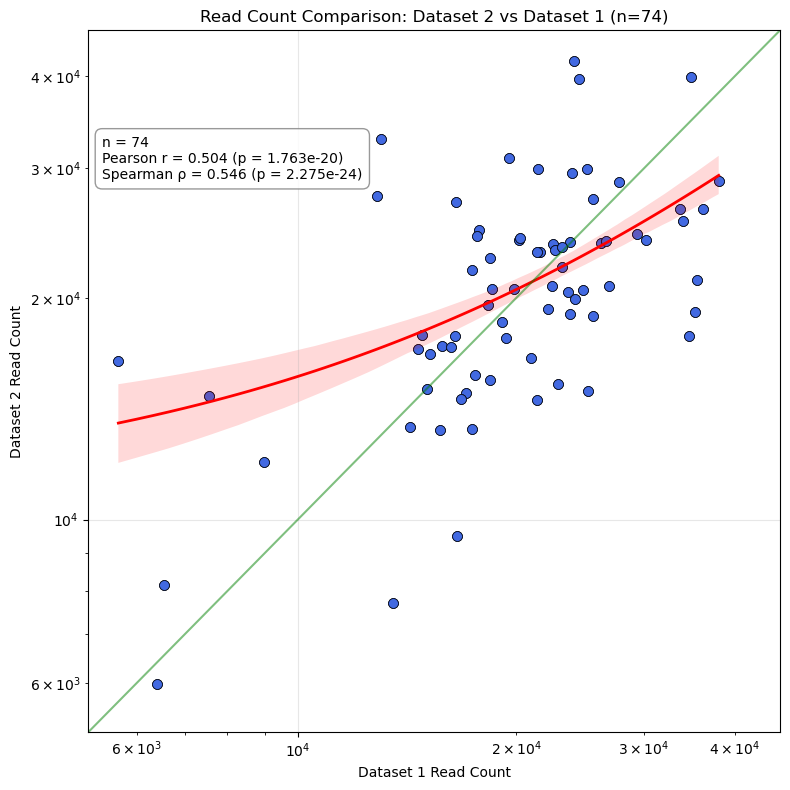

/tmp/ipykernel_41868/249908464.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_41868/249908464.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


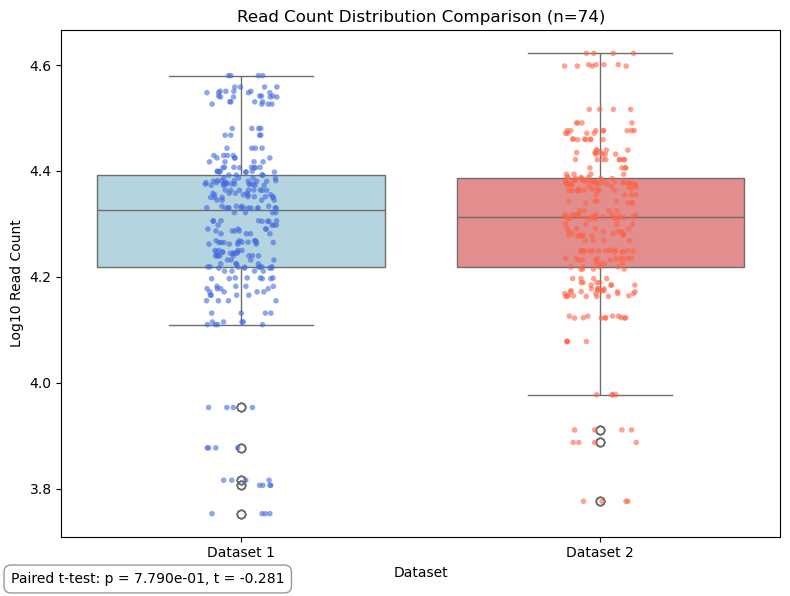

Visualizations complete.

Analysis complete! Results saved to 'metapool_test' directory.
Generated files:
  - processed_plate_map.csv: Processed plate map with sample information
  - dataset_1_read_counts.csv: Read counts from first FASTQ directory
  - dataset_2_read_counts.csv: Read counts from second FASTQ directory
  - read_count_comparison.csv: Paired comparison data
  - read_comparison_scatter.png: Scatter plot comparing read counts
  - read_count_boxplot.png: Box plot distribution comparison

Summary Statistics:
  Total samples in plate map: 192
  Samples found in dataset 1: 74
  Samples found in dataset 2: 74
  Valid paired samples: 296
  Pearson correlation: 0.504 (p = 1.763e-20)
  Dataset 1 mean reads: 21173
  Dataset 2 mean reads: 21107
  Mean fold change (Dataset 2/Dataset 1): 1.07
  Median fold change: 1.00


In [13]:
print("Creating visualizations...")
create_simple_visualizations(merged, output_dir)

print(f"\nAnalysis complete! Results saved to '{output_dir}' directory.")
print(f"Generated files:")
print(f"  - processed_plate_map.csv: Processed plate map with sample information")
print(f"  - dataset_1_read_counts.csv: Read counts from first FASTQ directory")
print(f"  - dataset_2_read_counts.csv: Read counts from second FASTQ directory")
print(f"  - read_count_comparison.csv: Paired comparison data")
print(f"  - read_comparison_scatter.png: Scatter plot comparing read counts")
print(f"  - read_count_boxplot.png: Box plot distribution comparison")

# print summary statistics
valid_data = merged.dropna(subset=["ReadCount_1", "ReadCount_2"])
if len(valid_data) > 0:
    print(f"\nSummary Statistics:")
    print(f"  Total samples in plate map: {plate_map['SampleID'].nunique()}")
    print(f"  Samples found in dataset 1: {fastq_df_1['SampleID'].nunique()}")
    print(f"  Samples found in dataset 2: {fastq_df_2['SampleID'].nunique()}")
    print(f"  Valid paired samples: {len(valid_data)}")
    
    pearson_corr, pearson_p = scipy.stats.pearsonr(valid_data["ReadCount_1"], valid_data["ReadCount_2"])
    print(f"  Pearson correlation: {pearson_corr:.3f} (p = {pearson_p:.3e})")
    
    # basic read count statistics
    print(f"  Dataset 1 mean reads: {valid_data['ReadCount_1'].mean():.0f}")
    print(f"  Dataset 2 mean reads: {valid_data['ReadCount_2'].mean():.0f}")
    
    fold_change = valid_data["ReadCount_2"] / valid_data["ReadCount_1"]
    print(f"  Mean fold change (Dataset 2/Dataset 1): {fold_change.mean():.2f}")
    print(f"  Median fold change: {fold_change.median():.2f}")

## Workflow Complete

The FASTQ comparison workflow is now complete. The generated files in your output directory contain:

- **Processed data**: CSV files with read counts and comparisons
- **Visualizations**: PNG files showing scatter plots and distribution comparisons
- **Summary statistics**: Correlation metrics and fold change analysis

You can modify the input parameters in Step 2 to analyze different FASTQ directories or plate maps.